# EDA for US Census data

In [2]:
import re
from summarytools import dfSummary
from janitor import clean_names
import pandas as pd
import numpy as np

# load feature names from metadata
metadata_file = open("./data/census_income_metadata.txt", "r")
metadata_lines = metadata_file.readlines()
columns = [re.findall(r"(\b[a-z\s'1-9]+\b):", line)[0] for line in metadata_lines[142:]]
columns.append("salary_threshold")

# load data and format cols
data = (
    pd.read_csv("data/census_income_learn.csv", names=columns, index_col=False)
    .pipe(clean_names)
    .assign(
        salary_threshold=lambda x: np.where(x["salary_threshold"] == " 50000+.", 1, 0)
    )
)

dfSummary(data)


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 34.5 (22.3)min < med < max:0.0 < 33.0 < 90.0IQR (CV) : 35.0 (1.5),91 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAp5JREFUeJzt3d2K2kAYgOFv6ipRIUEseuYNFHrgoRfRi+0lVPAKvAPPhCAR0w3GmJ5sCwtt12RmNvNl3+c8OpDXIT+TaOq6FiB0n7oeAPCIp64H4IsxZiwiI4uPuNZ1/exqPLDzZqiWO7yTnW2MGc/n829xHM/afsb5fD4ZY74Taxj+G6rtDu9wZ4/iOJ5tNpvnJEmKphtnWRZtt9tFmqafjTHnFt/PbOzYWzNq6x2eZVm02+1maZqORKSTnZYkSbFYLH423S7P82FZll9Xq9VgMBg0Dp3Z2L2HjlHb7vCqqmIRiY0xjQf2opOZ6Xq9PkVRNFmv18VyuTw12TaEH2gfeTuZsp2VRLqfmabTaasfqIiMnQ/mg/MWqs2sJMLMhNe8X56ymJVEmJnwggv+UIFQoQKhQgVChQqEChWCXpRSVdVQ2t0wiO/3+9DDkNCRYEO1uWFQlmVUVdWXoih+iEjbS2MISLCh2twwOBwOs/1+P7ndbgNf48P7CjbU39rcMDidTtwo6JngQ9XI4thahCWCf0WojrFE0A9CdYwlgn4QqicsEXSLC/5QgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQosSgmM5VpWkZ6uZyXUgPThxXK+EGpAeLHcvxFqgGxeLGf5TtpgDxsItUf6/BgMofZInx+DIdQe6uNjMFxHhQqEChUIFSoQKlQgVKjAWT/+CHmdAaFCRMJfZ0CoEJHw1xkQKl4J9Q/sOJmCCoQKFQgVKhAqVCBUqECoUIFQoQLXUeGMz78tIlQ44ft5LUKFE76f1yJUOOXreS1OpqACoUIFQoUKhAoVCBUqECpUIFSo8NB11CzLoqYffLlcIhGRPM+j4/E4ec/ttX631nHbbv9IX78AJEvXV93E12gAAAAASUVORK5CYII="">",0(0.0%)
2,class_of_worker[object],1. Not in universe2. Private3. Self-employed-not incorporate4. Local government5. State government6. Self-employed-incorporated7. Federal government8. Never worked9. Without pay,"100,245 (50.2%)72,028 (36.1%)8,445 (4.2%)7,784 (3.9%)4,227 (2.1%)3,265 (1.6%)2,925 (1.5%)439 (0.2%)165 (0.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADPCAYAAADifqNtAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA6RJREFUeJzt3U9OG2cAh+HPFkrLxhZC4gjtjgP4ED1sD+EDsOwdEGIWJc3GXTSN0iqQP/K8g83z7LL7iF7NaEbzg9XhcBhQWC99AN4OsZERGxmxkREbGbGRERuZ1RjjcozxbumDnKAPh8PhaelDnJKL6+vr3zabzdXSBzk10zQ9rFar3wX37S42m83Vbrd72m6375c+zKl4fHz8eb/fX93f378bY4jtG12MMcZ2u31/c3Pz59KHOTGXSx/g1HhAICM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI3Mxxj+fzCx9kFPi/+vHXEzT9LDf76+GT2a+yzRND2OMD0uf45T4LPzH+Sz8O638rg8qb+HK5gr0Spz94MUw5fU468GLYcrr8hYGL56yXwkvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Mic9eDlXH+uU3X2gxfDlNfDZ+FkDF7IeEAg87XbqFsQR/PiusoyiWN6dl1lmcSxfW1ddZavQ1iGBwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyz66rLJM4thfXVZZJHJPPwslYV5F56crmqsZRPTt4MXbh2L44eDF2YQ4vDV6MXTgqL3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIfHHwYuzCHJ4dvBi7cGw+Cydj8ELm/1c2VzNm85/Bi5ELc1r/O3jZ7XZPH6M75z8HyYI+DV4+/tvIhdl4qUtGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGSe/XNCcGyfr6ssqpiVDQIZ6yoyrmxkrKvIWFeRsa4i46UuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGYMXMgYvZHwWTsbghcznVzZXNWb1afBi7MLc1pvN5ur29nYYuzC39RhjXF5e/rX0QTh/XuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZ9RhjPD09/bT0QTh/62maHu7u7iyrmJ0NAhnrKjIeEMisV6vVr6vVyq9fYHbrMcYvYwxPo8zObZSM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcx6jPHHGMMvcGZ2Nghk3EbJiI2MwQsZgxcybqNkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRm3UTJiIyM2MmIjIzYyYiMjNjJ/A2cjW/of/K5MAAAAAElFTkSuQmCC"">",0(0.0%)
3,detailed_industry_recode[int64],Mean (sd) : 15.4 (18.1)min < med < max:0.0 < 0.0 < 51.0IQR (CV) : 33.0 (0.8),52 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAudJREFUeJzt3b1P20AYgPH3GoguSXuHSRS2rAxIHZBYsnTryB/L2q1DkDqzMrEgRAiOEuLGGHeiUlUJx74Y/EbPb+Y+JD+Kz/aAyfNcgKb79NEbADaxV/QHxpiOiLQrzr/O83xVcSzw15uhGmM6/X7/3DkXVZl8Pp/PjDEXxIpQRb+obedcNB6PV977pMzEcRzbyWQSTafTtogQKoIU3vpFRLz3yXA4fKowf6fCGOA/PExBBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSosNG/Qcf7McZ0RKQdMMU6z/PVtvbTFITaIMaYTr/fP3fORVXnmM/nM2PMxa7FSqjN0nbORePxeOW9T8oOjuPYTiaTaDqdtkWEUFEv730yHA6fKg7vVF23y

### Correlations with salary_threshold

<Figure size 1000x1000 with 0 Axes>

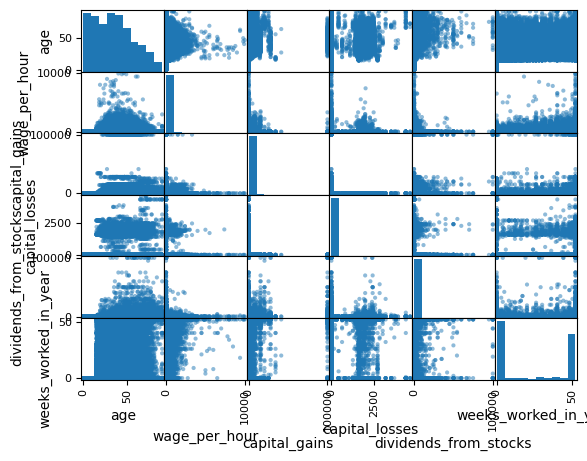

In [15]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

num_features = [
    "age",
    "wage_per_hour",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "weeks_worked_in_year",
]

plt.figure(figsize=(10, 10))

scatter_matrix(data[num_features])

plt.show()

### Correlations with categorical variables


c:\Users\Nick\miniconda3\envs\ml\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


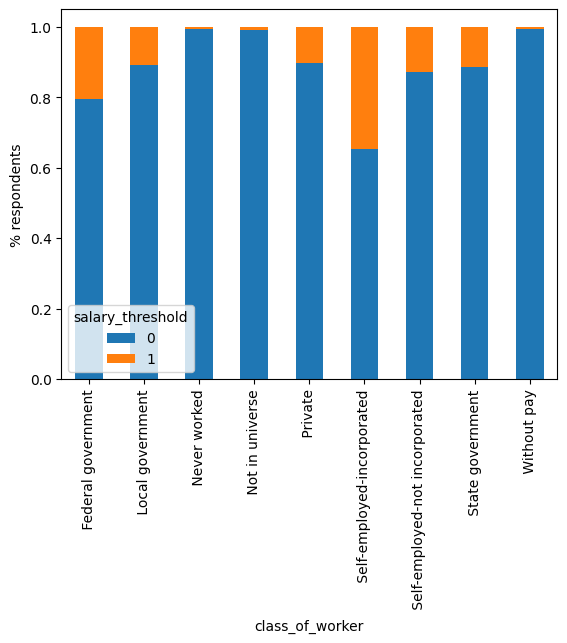

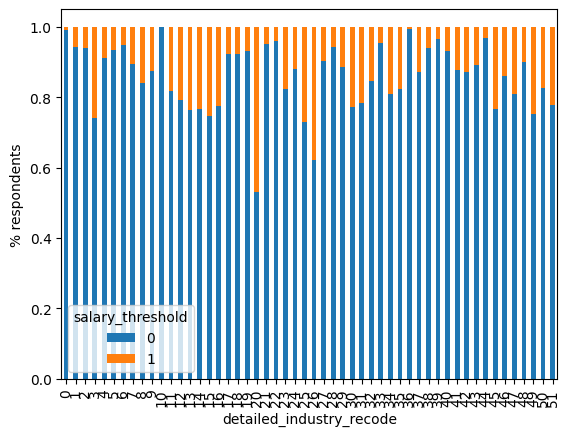

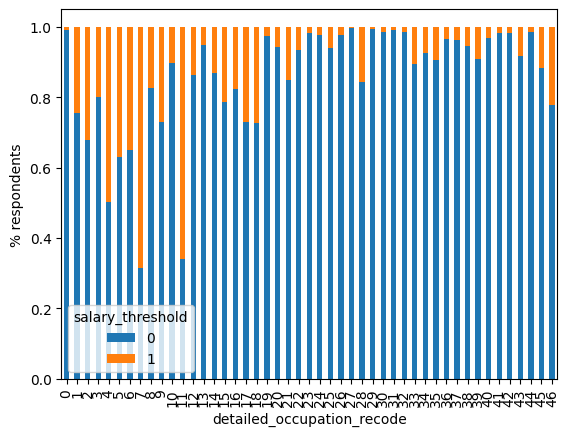

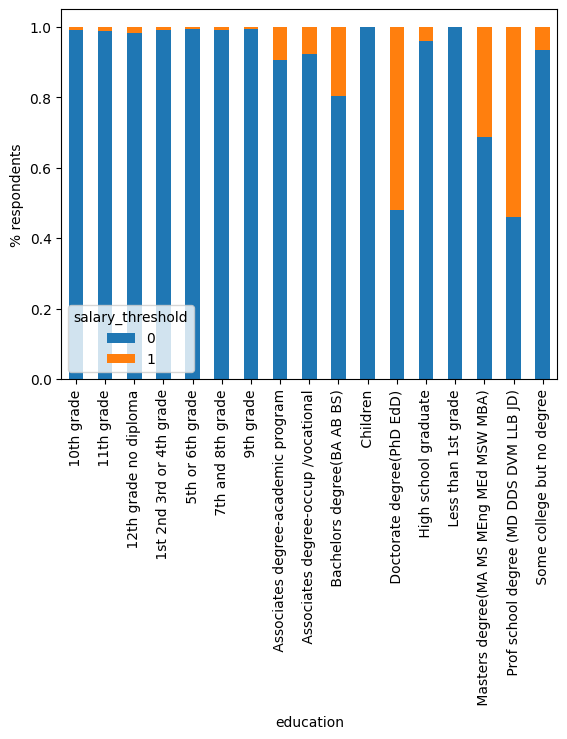

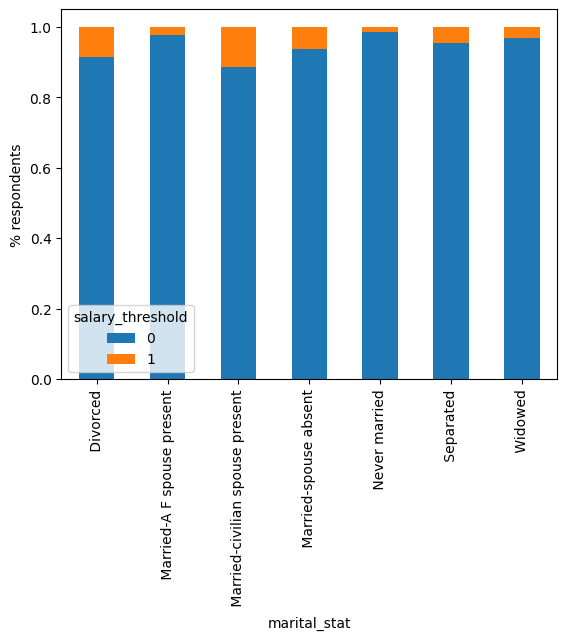

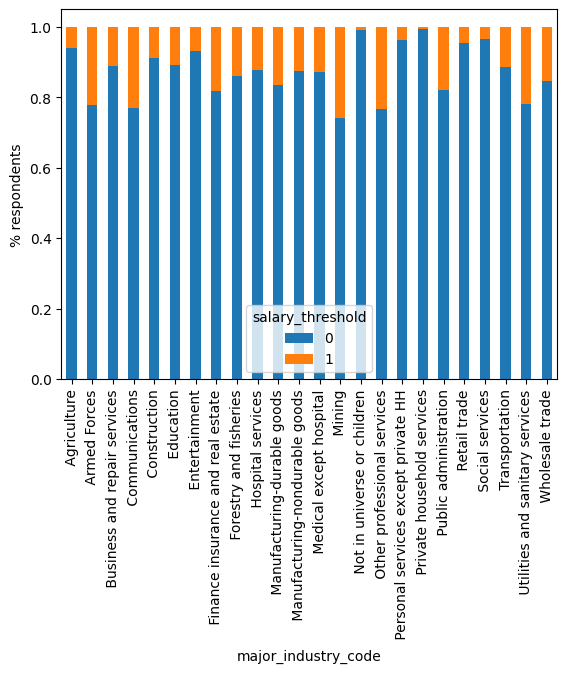

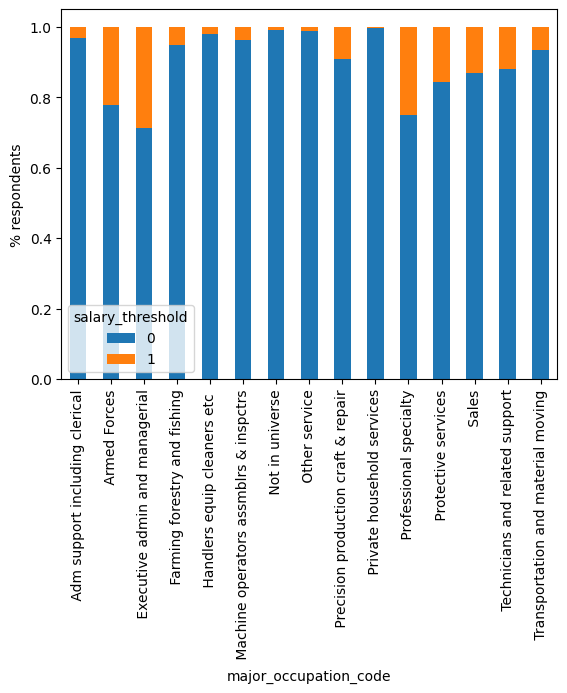

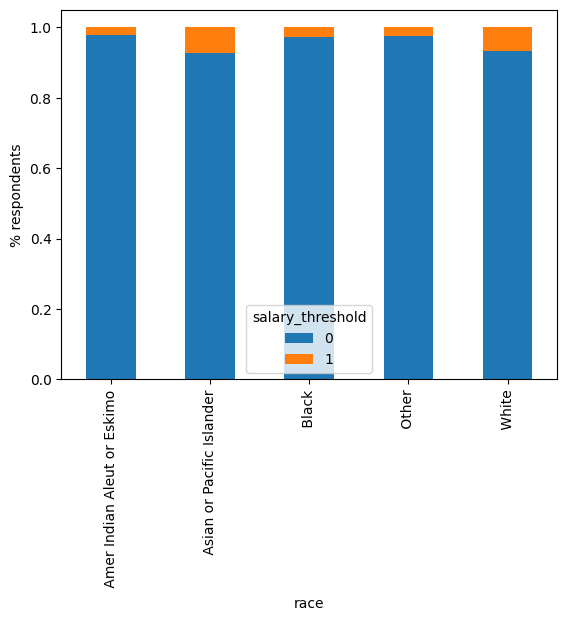

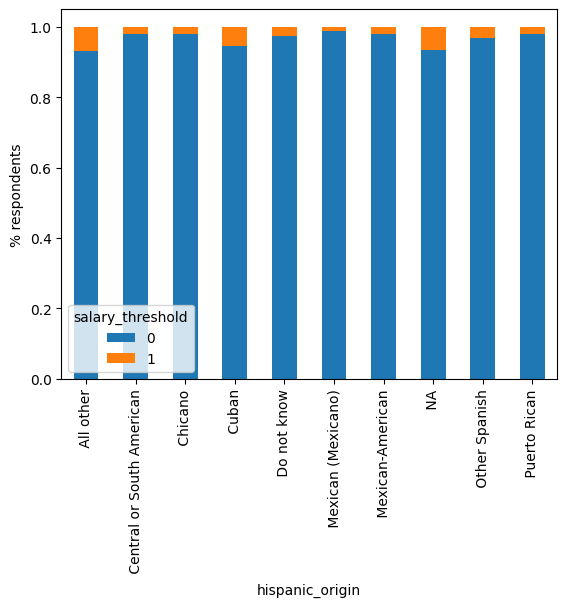

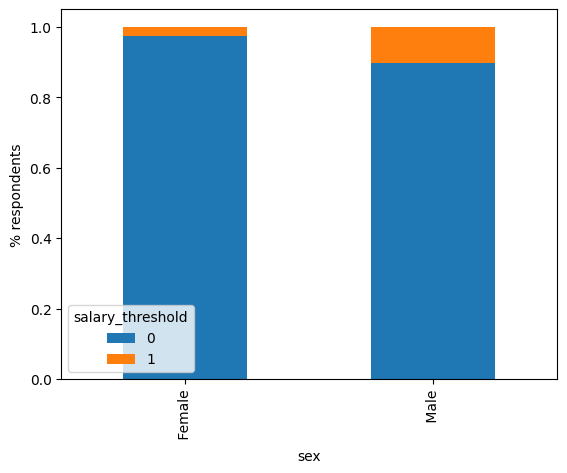

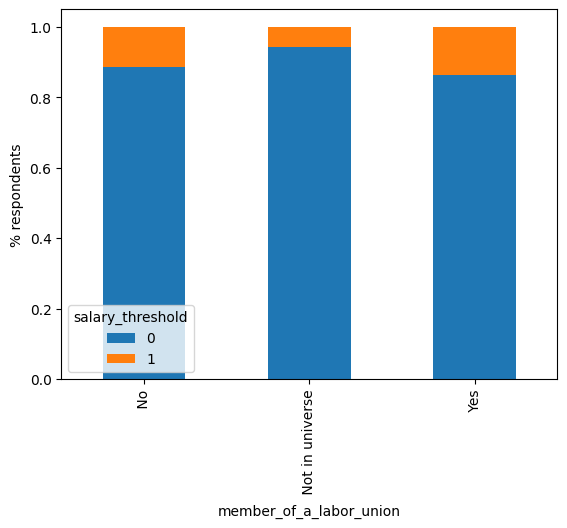

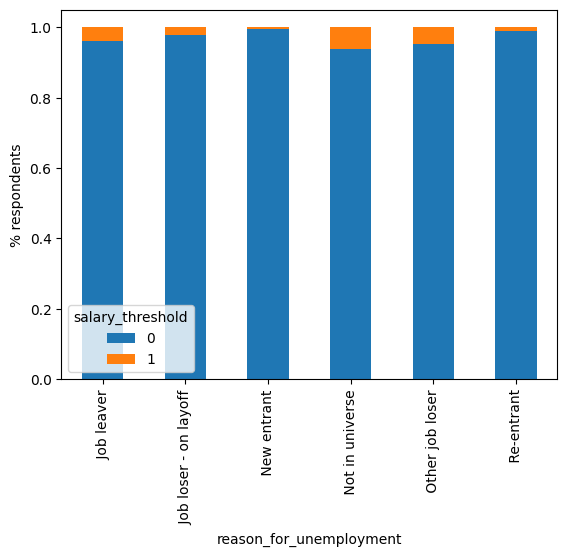

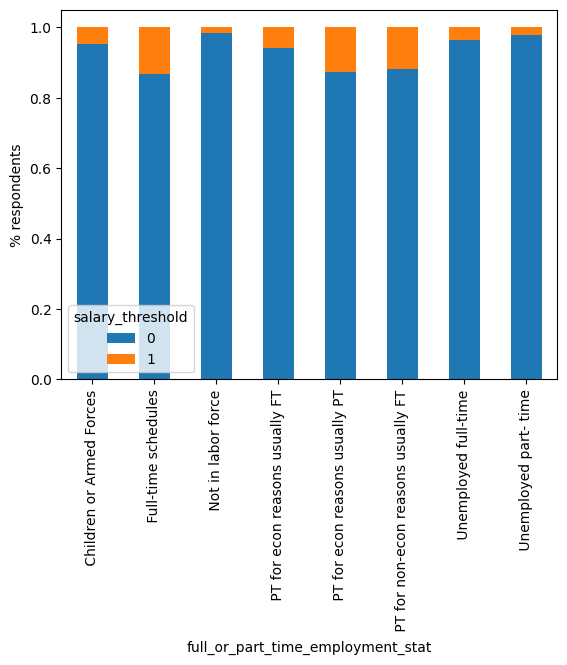

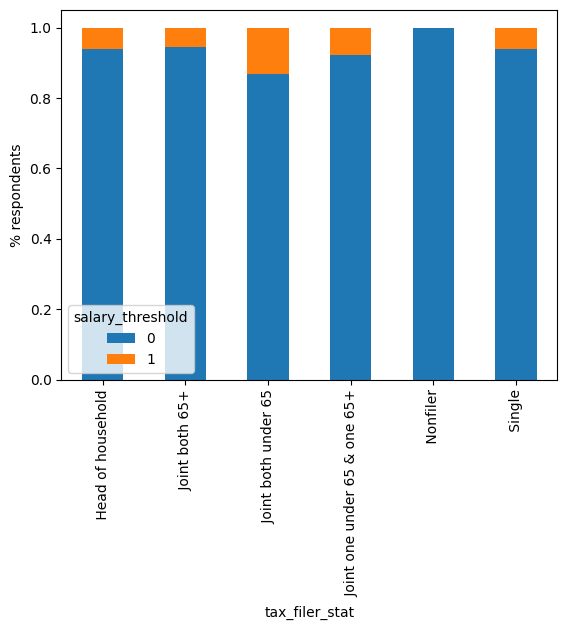

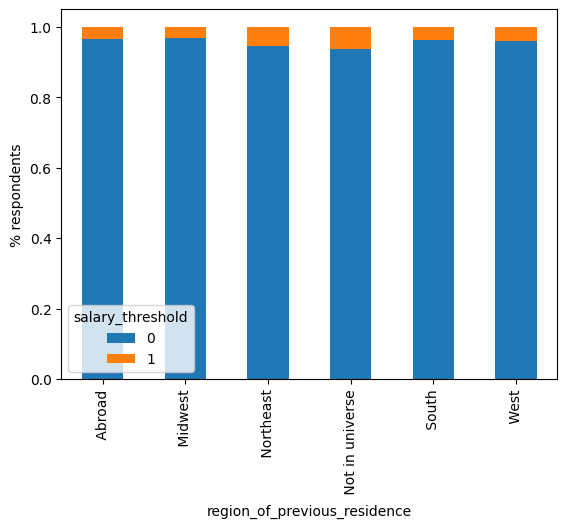

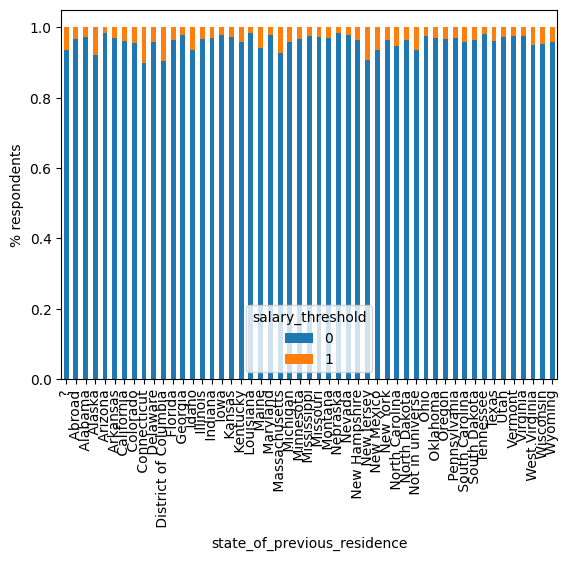

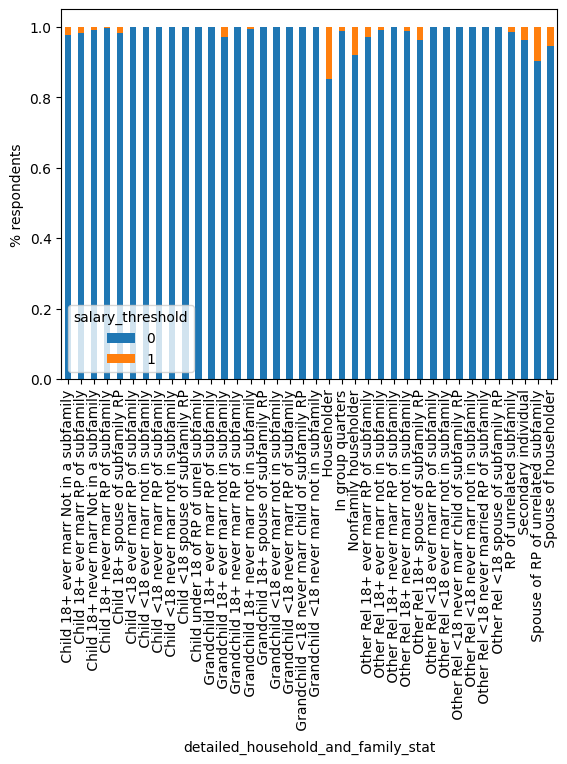

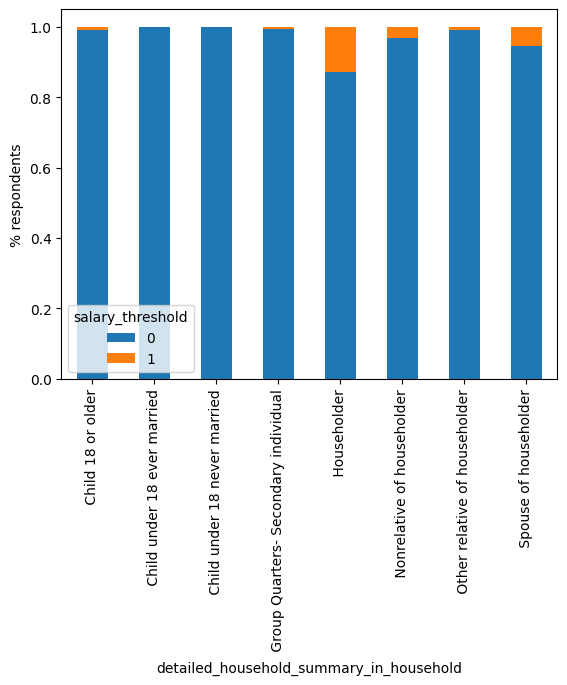

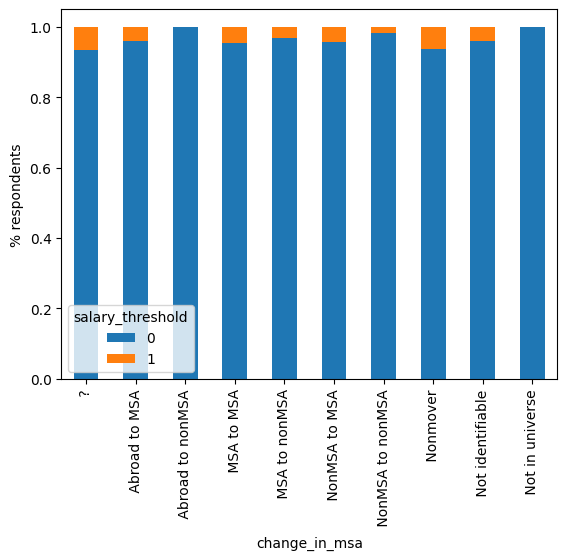

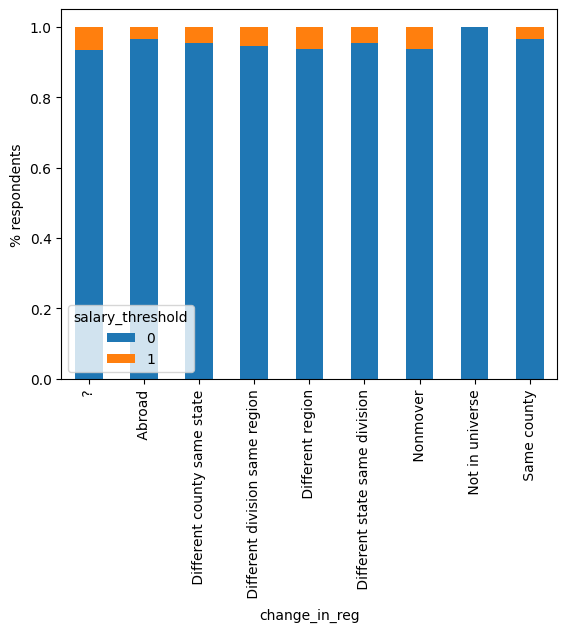

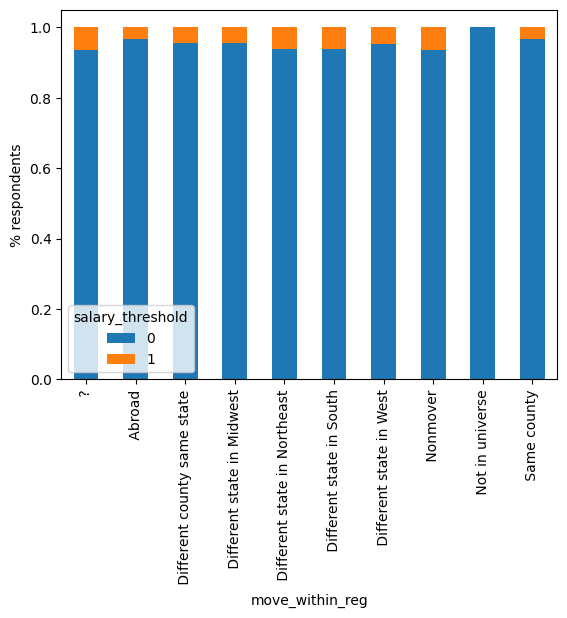

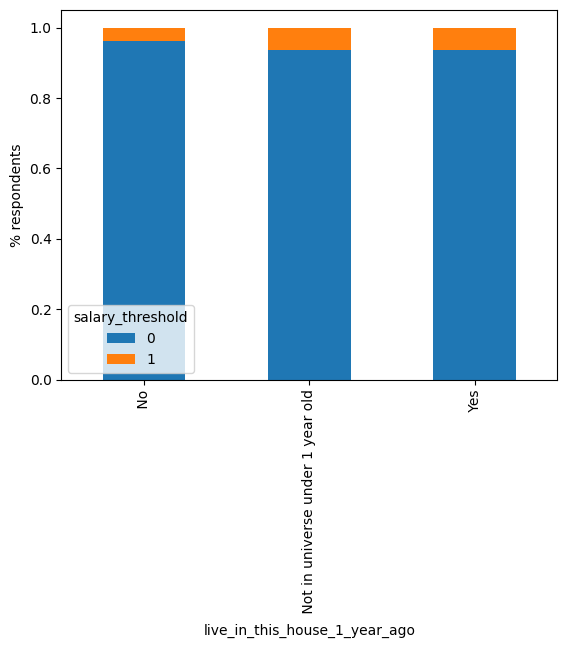

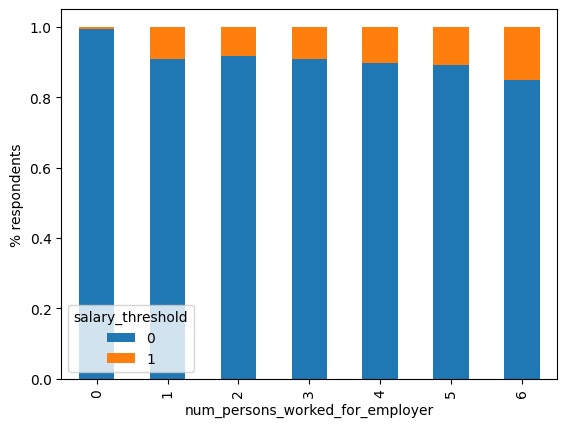

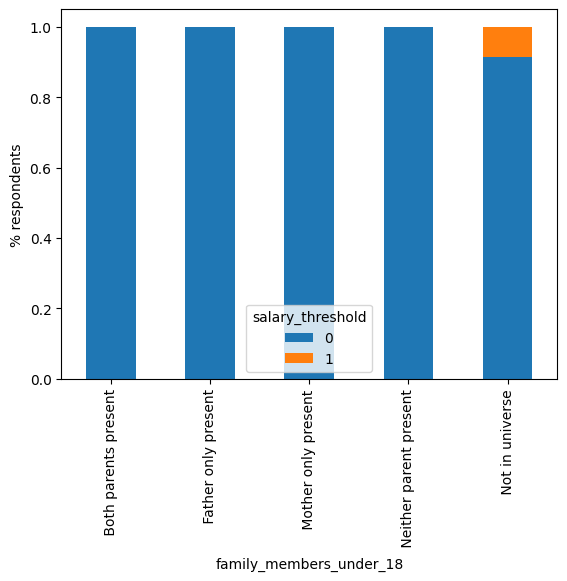

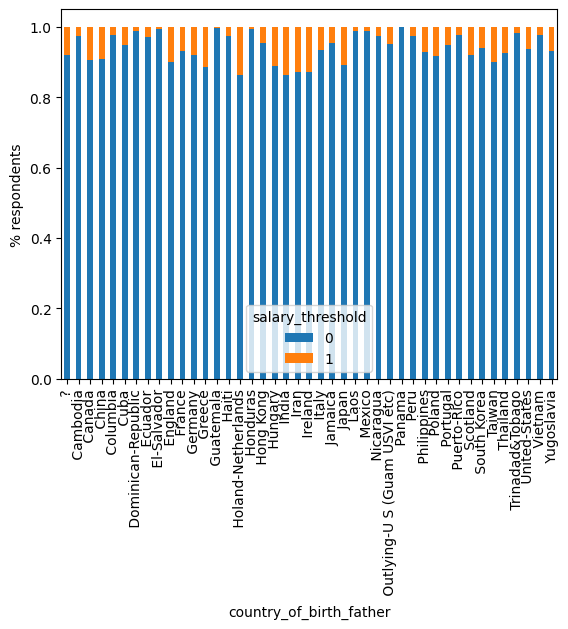

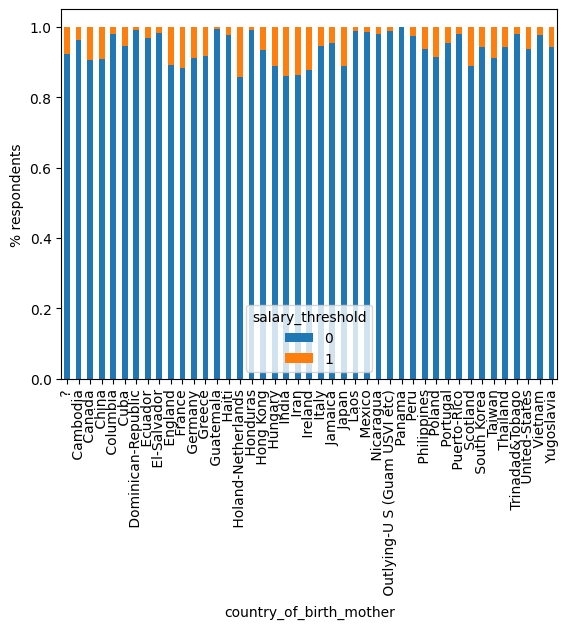

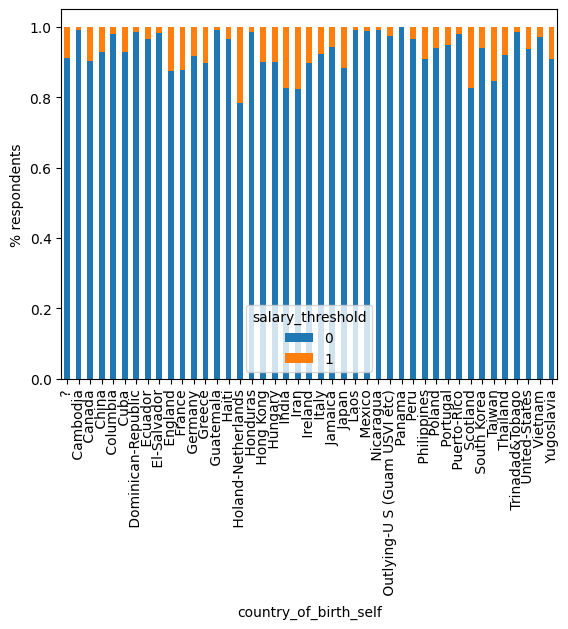

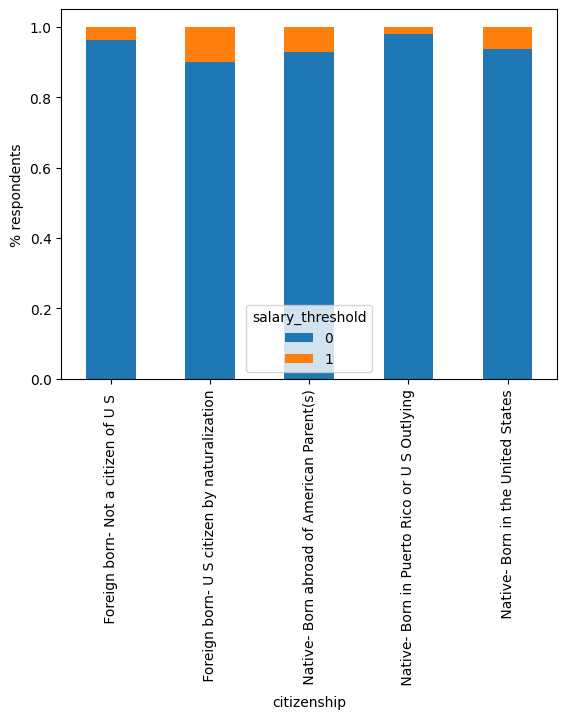

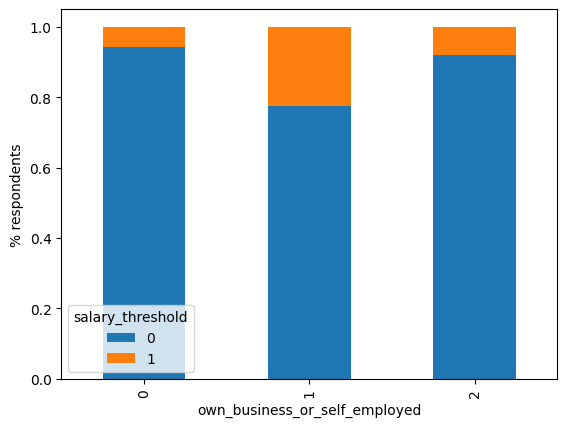

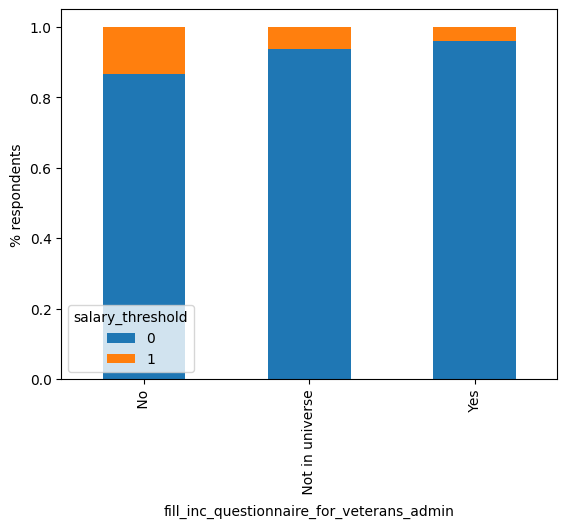

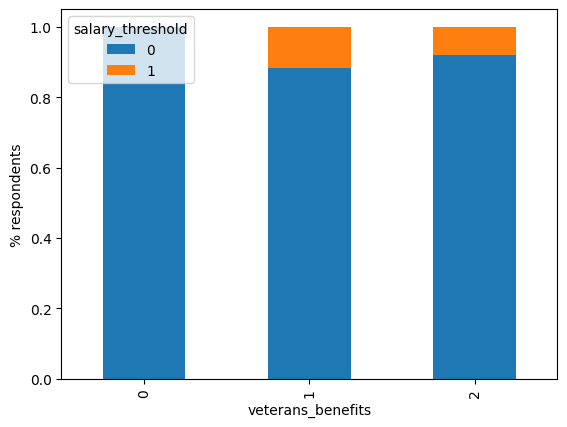

In [26]:
import seaborn as sns

cat_features = [
    "class_of_worker",
    "detailed_industry_recode",
    "detailed_occupation_recode",
    "education",
    "marital_stat",
    "major_industry_code",
    "major_occupation_code",
    "race",
    "hispanic_origin",
    "sex",
    "member_of_a_labor_union",
    "reason_for_unemployment",
    "full_or_part_time_employment_stat",
    "tax_filer_stat",
    "region_of_previous_residence",
    "state_of_previous_residence",
    "detailed_household_and_family_stat",
    "detailed_household_summary_in_household",
    "change_in_msa",
    "change_in_reg",
    "move_within_reg",
    "live_in_this_house_1_year_ago",
    "num_persons_worked_for_employer",
    "family_members_under_18",
    "country_of_birth_father",
    "country_of_birth_mother",
    "country_of_birth_self",
    "citizenship",
    "own_business_or_self_employed",
    "fill_inc_questionnaire_for_veterans_admin",
    "veterans_benefits",
]


def plot_categorical(feature, target):
    sns.histplot(
        binwidth=0.1,
        x=feature,
        hue=target,
        data=data,
        stat="count",
        multiple="stack",
    )


for feature in cat_features:
    (
        data.groupby(feature)["salary_threshold"]
        .value_counts(normalize=True)
        .unstack("salary_threshold")
        .plot.bar(stacked=True)
        .set_ylabel("% respondents")
    )


### Explore missing values

Large proportions of some features are labelled as 'not in universe' - this suggests that some survey questions are not applicable to certain observations eg. because they are children or pensioners. These may therefore contatain predictive value and not imputed.

I'll create a new categorical variable to detect working age and determine whether this explains the majority of the 'not in universe' values. The US Department of Labour restricts working hours for under 16 year olds.


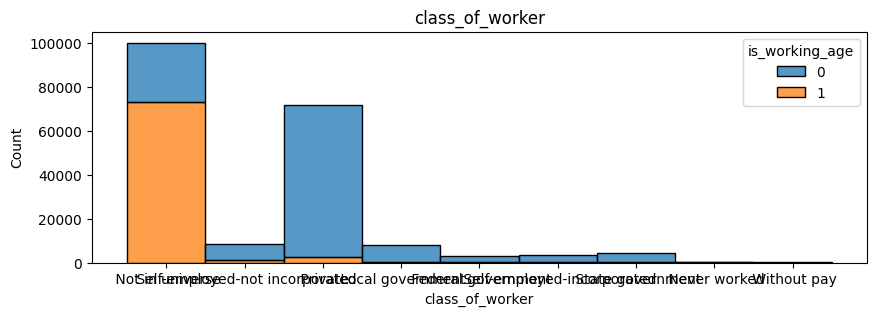

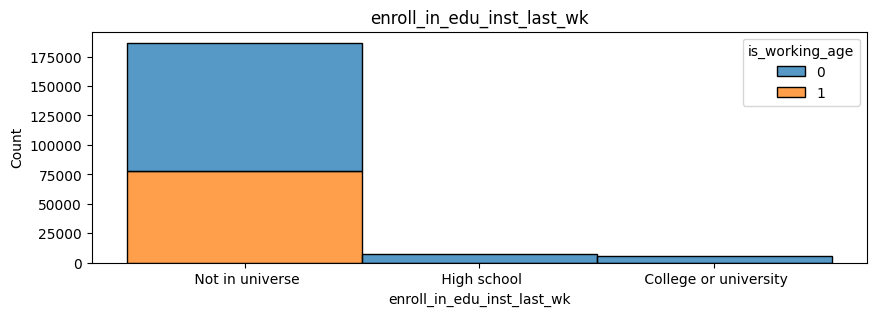

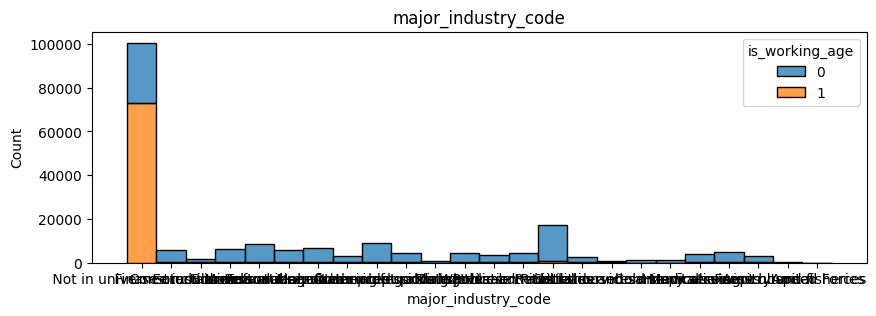

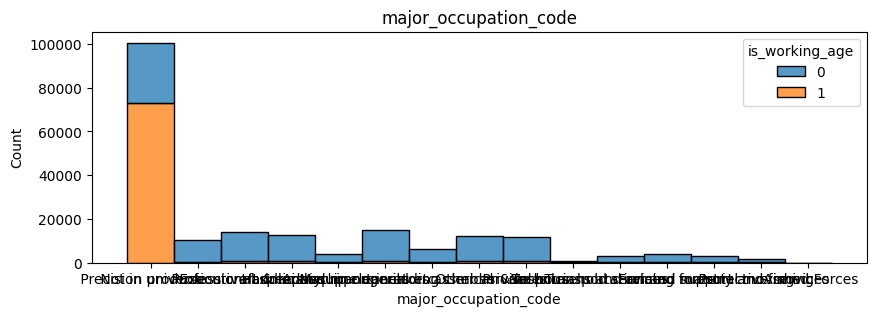

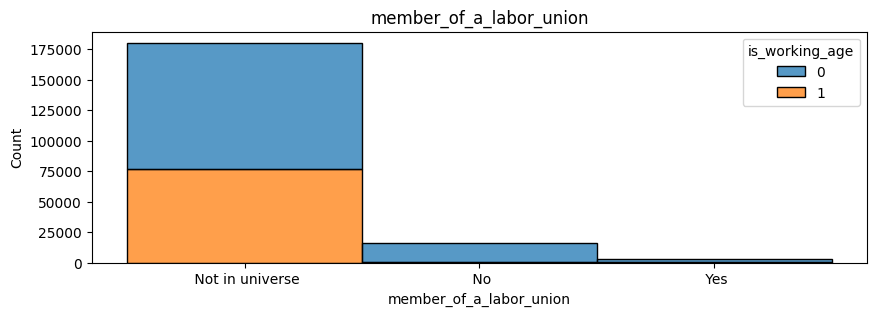

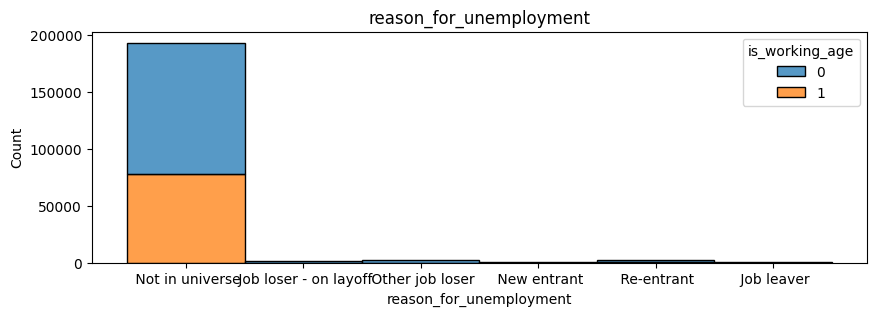

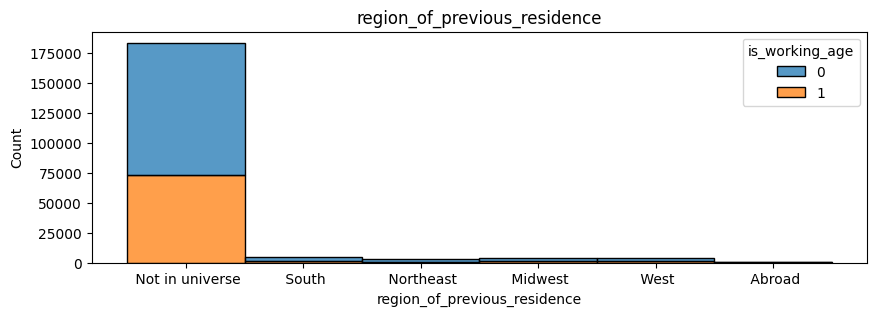

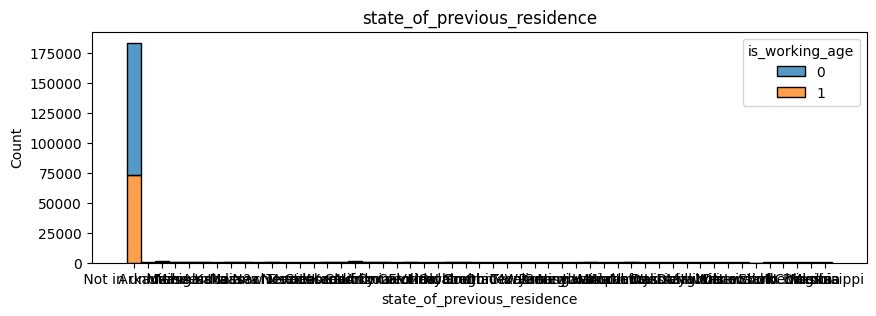

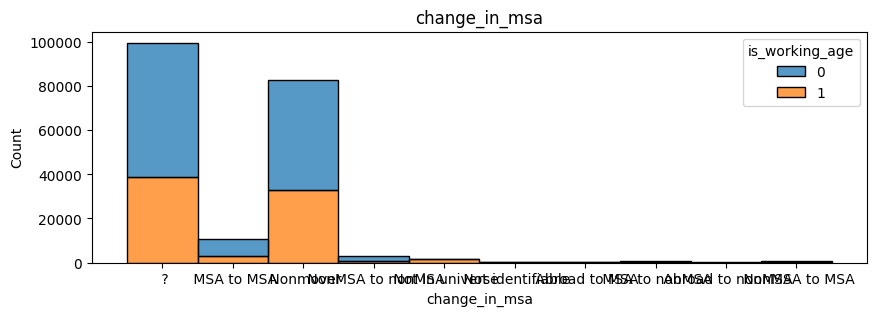

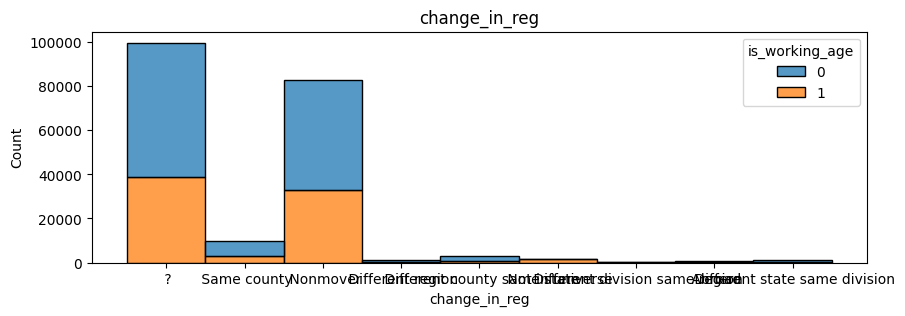

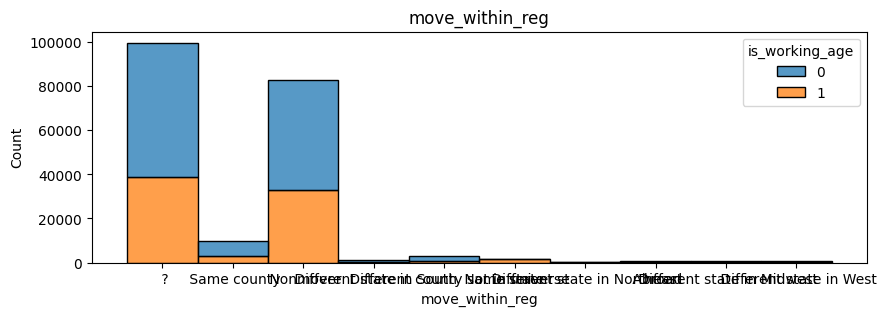

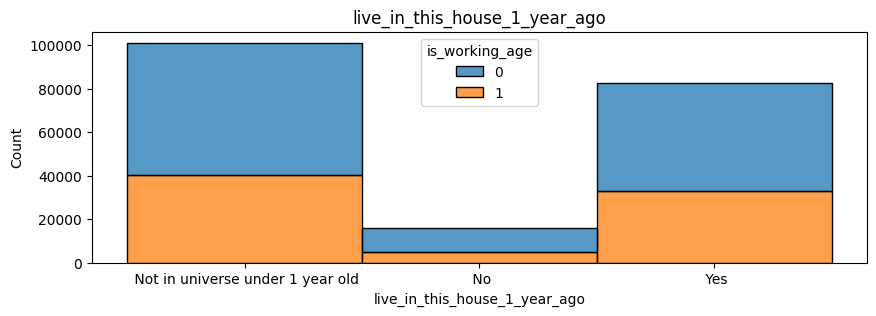

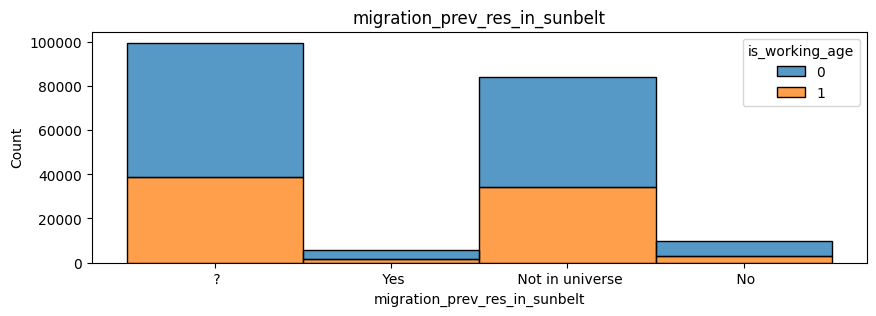

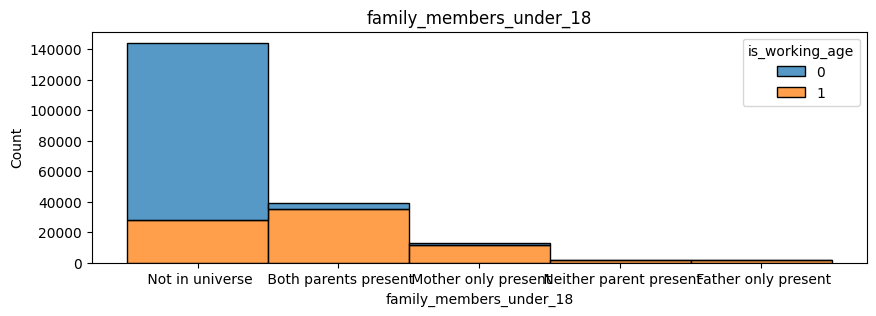

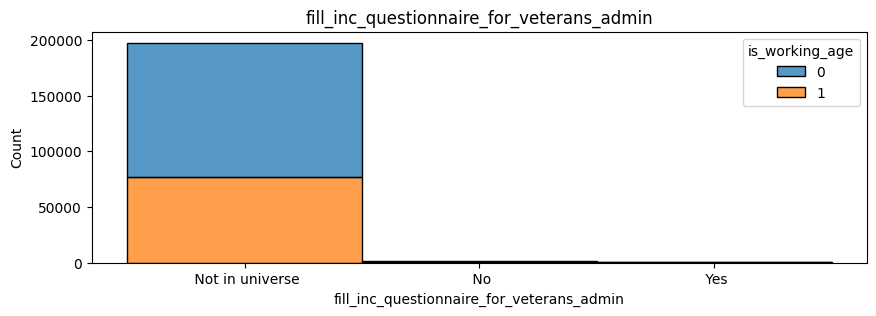

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

data = data.assign(
    is_child=lambda x: np.where(x["age"] >= 16, 0, 1),
    is_retirement_age=lambda x: np.where(x["age"] <= 62, 0, 1),
    is_working_age=lambda x: np.where((x["age"] >= 16) & (x["age"] <= 62), 0, 1),
)


niu_features = [
    "class_of_worker",
    "enroll_in_edu_inst_last_wk",
    "major_industry_code",
    "major_occupation_code",
    "member_of_a_labor_union",
    "reason_for_unemployment",
    "region_of_previous_residence",
    "state_of_previous_residence",
    "change_in_msa",
    "change_in_reg",
    "move_within_reg",
    "live_in_this_house_1_year_ago",
    "migration_prev_res_in_sunbelt",
    "family_members_under_18",
    "fill_inc_questionnaire_for_veterans_admin",
]

for feature in niu_features:
    plt.figure(figsize=(10, 3))
    plt.title(feature)
    plot_categorical(feature, "is_working_age")

plt.show()


A significant proportion of the NIU values are explained by the respondent not being of working age, but in all cases there is a significant proportion of working age individuals that are NIU.